<a href="https://colab.research.google.com/github/vedvatsal3/Life-Long-Machine-Learning/blob/main/Curriculum_Learning_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Curriculum Learning

In this tutorial, we will explore various Curriculum Learning strategies, as discussed in Lecture []. Traditionally, neural networks are trained on entire datasets using mini-batch updates. However, in this notebook, we take a different approach by dividing the dataset into smaller segments or bins of data. We will analyze the model's performance as it progressively trains on these bins for certain epochs until it has processed all the bins. Such a training paradigm has shown to reduce the training time complexity in manifolds as well as assisting the model to convergae better as can be seen in the figure below.
<p align="center">
<img src="loss_curve.png" alt=""/>
</p>

So our final goal of this notebook would be achieve such as loss curve at the end of the training cycle.

As part of this notebook, we will try to replicate the observations as presented in one of the pioneering works in Curriculum learning by [Yoshua Bengio](https://dl.acm.org/doi/pdf/10.1145/1553374.1553380). We will closely follow the training setup discussed in this work where the authors try to train a language model with Wiki Text dataset in a Curriculum fashion. So, it would be highly recommended to first go through this paper and then try to solve this notebook.

The notebook will broadly be divided into three main parts:
- Implement curriculum learning with a simple language model on textual data
- Investigate the implications behind anti-curriculum learning strategy.
- Finally, we explore the efficacy of LSTMs to generate texts in curriculum fashion.




Let us begin with the installing the necessary libraries

In [ ]:
"""
For pytorch 2.0 use '!pip install torchdata'
"""
## Install the necessary packages
# use only if necessary

!pip install torch==2.3.0 torchtext==0.18.0

## Check the installed versions
!pip show torch torchtext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

Name: torch
Version: 2.3.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-nccl-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchaudio, torchdata, torchtext, torchvision
---
Name: torchtext
Version: 0.18.0
Summary: Text utilities, models, transforms, and datasets for PyTorch.
Home-page: https://github.com/pytorch/text
Author: PyTorch Text Team
Author-email: packages@pytorch.org
License: BSD
Location: /usr/local/lib/python3.11/dist-packages
Requires: numpy, requests, torch, tqd

In [ ]:
import torch
import random
import re
from tqdm import tqdm
from typing import Tuple
from typing import Optional
from torch import nn, Tensor
from collections import Counter
import matplotlib.pyplot as plt
from torchtext.vocab import vocab
from torch.utils.data import dataset
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import build_vocab_from_iterator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.11/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.11/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.11/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

2. Let us now load the dataset.
- In this notebook, we will use one of the most popular text datasets, WikiText2. The dataset is a collection of over 100 million tokens extracted from the set of verified Good and Featured articles on Wikipedia. The dataset is commonly used in the scope of language modeling.
- We have provided the dataset in the form of a .txt file for ease of use.

In [ ]:
# change the path and name of the files accordingly

with open("wiki.train.txt", "r") as train, \
     open("wiki.valid.txt", "r") as val, \
     open("wiki.test.txt", "r") as test:

    train_data = train.readlines()
    val_data = val.readlines()
    test_data = test.readlines()

    valid_data =  val_data + test_data



3. Data Preprocessing

- Now, we will proceed to clean the raw text file. We will try to remove anything except the words with english alphabets, that is, remove punctuations, special characters, extra white spaces, and numerical characters.

Feel free to use one of the widely used libraries to process the data such as nltk, RegEx


In [ ]:
### Preprocess the data: Both for training and validation data

for i in range(len(train_data)):
    train_data[i] = re.sub("\s+", " ", train_data[i]) # Remove the extra spaces
    train_data[i] = re.sub("\d+", " ", train_data[i]) # Remove the digits
    train_data[i] = re.sub("[^a-zA-Z]+", " ", train_data[i]) # Remove the unwanted characters (anything other than a-z, A-Z)

for i in range(len(valid_data)):
    valid_data[i] = re.sub("\s+", " ", valid_data[i])     #same
    valid_data[i] = re.sub("\d+", " ", valid_data[i])
    valid_data[i] = re.sub("[^a-zA-Z]+", " ", valid_data[i])

4. Define a tokenizer and create a vocabulary for the dataset
- In this notebook, we will use the basic_english tokenizer from torchtext to tokenize the text data.
- We will then create a vocabulary from the training data using the build_vocab_from_iterator function from torchtext.


In [ ]:
## Tokenizer
tokenizer = get_tokenizer('basic_english')

### VOcalbulary class
class Vocabulary(Dataset):
  def __init__(self, wikidata, tokenizer):
    self.tokenizer = tokenizer
    self.wikidata = wikidata

    # actual length of train vocab is 66057

    self.corpus_vocab = build_vocab_from_iterator(map(self.tokenizer, wikidata), max_tokens= 30000)
    self.corpus_vocab.set_default_index(0)

  def word_to_idx(self, word): # word_to_idx: This method should return the index of the word in the vocab
    return self.corpus_vocab.get_stoi()[word]

  def idx_to_word(self, idx): # idx_to_word: This method should return the word given the index
    return self.corpus_vocab.get_itos()[idx]

  def __len__(self): # __len__: This method should return the length of the vocab
    return len(self.corpus_vocab)

Convert raw text into tensor tokens

- Create a function to transform the text data into a tensor of indices
- Use the vocabulary object and the tokenizer to transform the raw text into a tensor of indices

In [ ]:
""" Converts raw text into a flat Tensor
**** ------------------- TO-DO ------------------- ****
### Define the data_process function
### The function should have the following arguments:
### 1. vocabulary: The vocabulary object
### 2. raw_text_iter: The raw text data
### The function should return a flat tensor of the raw text data

"""

def data_process(vocabulary, raw_text_iter: dataset.IterableDataset) -> Tensor:
    data = [torch.tensor(vocabulary.corpus_vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]

    return torch.cat(tuple(filter(lambda t: bool(t.numel()), data)))


Dataset and Dataloaders

- We are now well placed to design the dataset class and the dataloaders accordingly.
- We would like to get window of tokens from the dataset class
- Experiment with the batch size, num_workers in dataloader object


In [ ]:

MAX_VOCAB =  27000
batch_size = 128

class Wikipedia_Dataloader(Dataset):
  def __init__(self, corpus, vocab_len): #This method should initialize the dataset
    self.corpus = corpus
    self.vocab_len =  vocab_len
    self.seq_len = 5

  def __len__(self): #This method should return the length of the dataset
    return len(self.corpus)

  def __getitem__(self, idx): #This method should return the data at the given index
    fs = self.corpus[idx : idx + self.seq_len]
    #print(self.vocab_len)
    random_index = torch.randint(1, self.vocab_len + 1, (1,))
    fsw = torch.cat((fs[:-1], random_index))
    #print(fsw.shape,fs.shape)
    return fs, fsw


# prepare data loaders
vocabulary = Vocabulary(train_data, tokenizer)
train_iter = data_process(vocabulary, train_data)
wiki_data_train = Wikipedia_Dataloader(train_iter, 20000)
data_loader = DataLoader(wiki_data_train, batch_size= batch_size, drop_last=True)

vocabulary_v = Vocabulary(valid_data, tokenizer)
val_iter = data_process( vocabulary_v, valid_data)
wiki_data_valid = Wikipedia_Dataloader(val_iter, 20000)
data_loader_valid = DataLoader(wiki_data_valid, batch_size= batch_size, drop_last=True)

In [ ]:
lr = 1e-3
epochs = 20
embed_dim = 50
batch_size = 128
hidden_units = 100


### Define a simple language model

- Step 1: Encode each word into a multi-dimensional vector embedding
- Step 2: Pass the embeddings through a simple multi-layer perceptron.
- Step 3: The model should output only a single word

HINT: If you had read the cited paper, we would have probably seen the authors have used look-up tables for embeddings. Use torch.nn.Embeddings function instead


In [ ]:
### Language Model
### The model should have the following layers:
### 1. Embedding layer
### 2. Flatten layer
### 3. Linear layer


class CurriculumLearning(nn.Module):
  def __init__(self, max_vocab, embed_dim, hidden_units):
    super(CurriculumLearning, self).__init__()
    self.embed = nn.Embedding(max_vocab, embed_dim)
    self.flat = nn.Flatten()
    self.linear_layers = nn.Sequential(
        nn.Linear(embed_dim *5 , hidden_units),
        nn.Tanh(),
        nn.Linear(hidden_units, 1),
    )

  def forward(self, x):
    x = self.embed(x)
    x = self.flat(x)
    x = self.linear_layers(x)
    return x

Before proceeding to Curriculum training, let us first conduct a joint training on entire vocabulary set.

For the sake of simplicity, we have choosen to use the first 20k words in our use case.
Define the following training attributes:

In [ ]:
## Initialize the model

## Define the loss function

## Define the optimizer

## Define the learning rate scheduler
model = CurriculumLearning(MAX_VOCAB, embed_dim, hidden_units).to(device)
print(model)
#model.cpu()
loss_fn = nn.MarginRankingLoss(margin=1.0)
optimizer_ = torch.optim.SGD(model.parameters(), lr = 1e-3)
scheduler_ = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_, T_max=4, eta_min=9e-3)

CurriculumLearning(
  (embed): Embedding(27000, 50)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear_layers): Sequential(
    (0): Linear(in_features=250, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)


#### Helper function to check whether a word falls into our pre-specified range of vocabulary of 20k words. IF not, we reject the complete window as also discussed in the paper


In [ ]:
def validate_window(fs_batch, fsw_batch, vocab_size) -> Tuple[Tensor, Tensor]:
    #print(vocab_size)
    condition = torch.logical_and(torch.all(torch.lt(fs_batch, vocab_size), dim=1), torch.all(torch.lt(fsw_batch, vocab_size), dim=1))
    indices = torch.nonzero(condition)


    if len(indices) == 0:
        return torch.tensor([]), torch.tensor([])

    valid_fs = torch.index_select(fs_batch, 0, indices.flatten())
    valid_fsw = torch.index_select(fsw_batch, 0, indices.flatten())

    return valid_fs, valid_fsw

#### Define the training loop and similarily the evaluation loop.

- Read windows of texts
- Validate it through the validate_window function

HINT: The structure should be the same for both of these functions

In [ ]:
def train(data: torch.utils.data.dataloader.DataLoader,
          model: nn.Module,
          optimizer,
          loss_fn,
          vocab_size: Optional[int] = MAX_VOCAB

          ):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.train()
    epoch_loss = 0
    d= 0
    for fs, fsw in tqdm(data):
      optimizer.zero_grad()
      correct_win, incorrect_win = validate_window(fs, fsw, vocab_size)
      if correct_win.numel() == 0:
        continue

      correct_score = model(correct_win.to(device))
      wrong_score = model(incorrect_win.to(device))

      target = torch.ones_like(correct_score)
      loss = loss_fn(correct_score, wrong_score, target)

      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()

    print(f"[Train] Loss: {epoch_loss/len(data):.4f}")

In [ ]:
def evaluate(data: torch.utils.data.dataloader.DataLoader,
          model: nn.Module,
          loss_fn,
          ):

    model.eval()
    ranks = torch.tensor([])
    epoch_loss = 0
    total_batches = 0

    with torch.no_grad():
      for fs, fsw in data:
        correct_win, incorrect_win = validate_window(fs, fsw, MAX_VOCAB)
        if correct_win.numel() == 0:
          continue

        correct_score = model(correct_win.to(device))
        wrong_score = model(incorrect_win.to(device))

        target = torch.ones_like(correct_score)
        loss = loss_fn(correct_score, wrong_score, target)

        epoch_loss += loss.item()
        ranks = torch.cat((ranks, torch.unsqueeze(loss, 0).to('cpu')))

    avg_rank = torch.mean(ranks)
    print(f"[Eval]  Loss:: {epoch_loss/len(data):.4f}")

    return avg_rank.item()

In [ ]:
### Start training the non-curriculum learning model
print('Training without Curriculum Learning \n----------------------------------------------------------')

collect_ranks = []    #torch.tensor([])
epochs= 4
for i in range(epochs):

  print(f'\nEpoch: {i + 1}/{epochs}')
  train(data_loader, model, optimizer_, loss_fn, vocab_size=20000)
  collect_ranks.append(evaluate(data_loader_valid, model, loss_fn))
  scheduler_.step()
  print(scheduler_.get_last_lr())

Training without Curriculum Learning 
----------------------------------------------------------

Epoch: 1/4


100%|██████████| 13238/13238 [00:54<00:00, 244.51it/s]


[Train] Loss: 0.7514
[Eval]  Loss:: 0.6898
[0.0021715728752538096]

Epoch: 2/4


100%|██████████| 13238/13238 [00:53<00:00, 245.78it/s]


[Train] Loss: 0.7188
[Eval]  Loss:: 0.6720
[0.004999999999999999]

Epoch: 3/4


100%|██████████| 13238/13238 [00:54<00:00, 244.12it/s]


[Train] Loss: 0.6668
[Eval]  Loss:: 0.5814
[0.00782842712474619]

Epoch: 4/4


100%|██████████| 13238/13238 [00:54<00:00, 244.31it/s]


[Train] Loss: 0.5164
[Eval]  Loss:: 0.4447
[0.009]


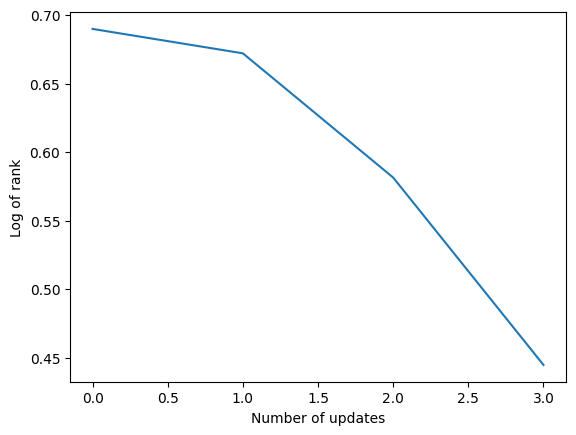

In [ ]:
fig, ax = plt.subplots()

x_cord = range(0, len(collect_ranks))
ax.plot(x_cord, collect_ranks)

ax.set_xlabel('Number of updates')
ax.set_ylabel('Log of rank')
plt.show()

We now transition to curriculum training. Model definition should be the same. However,unlike joint training, now we need to train our model with bins in a curriculum fashion. In this case, we will equally divide the data in terms of vocab size into four bins. That means, we will first training on first 5000 vocab words and then progressively add 5000 more words to the vocab until we reach 20k words. We simply reject any window with words outside the specified vocab range.

In [ ]:
# ***********************************************************
# training with Curriculum Learning
# ***********************************************************

model_curriculum = CurriculumLearning(27000, embed_dim, hidden_units).to(device)
loss_fn = nn.MarginRankingLoss(margin=1.0)
optimizer = torch.optim.SGD(model_curriculum.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=4, eta_min=9e-3)


In [ ]:
"""
1. Segment the training data into 4 parts
2. Create the data loaders for each part
3. Create the data loader for the validation data- it will be the same as we had defined for the non-curriculum learning model
"""
vocabulary = Vocabulary(train_data, tokenizer)
train_iter = data_process(vocabulary, train_data)
train_loader = []
for i in range(4):

    wiki_data_train = Wikipedia_Dataloader(train_iter,5000*(i+1))
    data_loader = DataLoader(wiki_data_train, batch_size= batch_size, drop_last=True)
    train_loader.append(data_loader)

vocabulary_v = Vocabulary(valid_data, tokenizer)
val_iter = data_process( vocabulary_v, valid_data)
wiki_data_valid = Wikipedia_Dataloader(val_iter, 20000)
data_loader_valid = DataLoader(wiki_data_valid, batch_size= batch_size, drop_last=True)


In [ ]:
def train(data: torch.utils.data.dataloader.DataLoader,
          model: nn.Module,
          optimizer,
          loss_fn,
          size: int,
          vocab_size: Optional[int] = MAX_VOCAB
          ):

    model.train()
    epoch_loss = 0
    data_length = 0
    d=0
    for fs, fsw in tqdm(data):
      optimizer.zero_grad()
      correct_win, incorrect_win = validate_window(fs, fsw, vocab_size)
      if correct_win.numel() == 0:
        continue

      correct_score = model(correct_win.to(device))
      wrong_score = model(incorrect_win.to(device))

      target = torch.ones_like(correct_score)
      loss = loss_fn(correct_score, wrong_score, target)

      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()

    #print(int(data_length/128))
    print(d)
    print(f"[Train] Loss: {epoch_loss/len(data):.4f}")


In [ ]:
'''
1. Train the model with curriculum learning
2. Use the same loss function and optimizer as we used for the non-curriculum learning model
3. Use the same learning rate scheduler as we used for the non-curriculum learning model
4. Use the same validation function as we used for the non-curriculum learning model
5. Use the same training function as we used for the non-curriculum learning model
'''

epochs = 1
ranks_cl = []
experiences = 4
vocab_init = 5000

print('Training with Curriculum Learning')
for exp in range(experiences):
  vocab_step = vocab_init * (1+exp)
  data_loader.dataset.vocab_len = vocab_step

  print('----------------------------------------------------------')

  for epoch in range(epochs):
    print(f'\nEpoch: ({epoch + 1}/{epochs}) | Experience: ({exp+1}/{experiences}) | Vocab size: {vocab_step}')
    train(train_loader[exp], model_curriculum, optimizer, loss_fn, 5000*(1+exp), vocab_step)
    ranks_cl.append(evaluate(data_loader_valid, model_curriculum, loss_fn))
    scheduler.step()
    print(scheduler.get_last_lr())

Training with Curriculum Learning
----------------------------------------------------------

Epoch: (1/1) | Experience: (1/4) | Vocab size: 5000


100%|██████████| 13238/13238 [00:55<00:00, 237.93it/s]


0
[Train] Loss: 0.7247
[Eval]  Loss:: 0.7058
[0.0021715728752538096]
----------------------------------------------------------

Epoch: (1/1) | Experience: (2/4) | Vocab size: 10000


100%|██████████| 13238/13238 [00:56<00:00, 233.45it/s]


0
[Train] Loss: 0.6927
[Eval]  Loss:: 0.6416
[0.004999999999999999]
----------------------------------------------------------

Epoch: (1/1) | Experience: (3/4) | Vocab size: 15000


100%|██████████| 13238/13238 [00:56<00:00, 235.59it/s]


0
[Train] Loss: 0.5851
[Eval]  Loss:: 0.5204
[0.00782842712474619]
----------------------------------------------------------

Epoch: (1/1) | Experience: (4/4) | Vocab size: 20000


100%|██████████| 13238/13238 [00:55<00:00, 238.26it/s]


0
[Train] Loss: 0.5107
[Eval]  Loss:: 0.4697
[0.009]


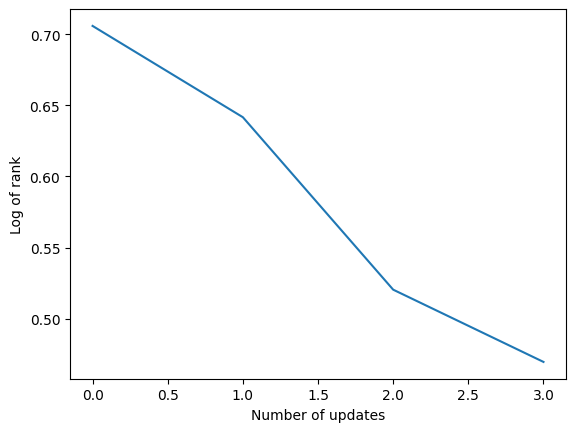

In [ ]:
fig, ax = plt.subplots()

x_cord = range(0, len(ranks_cl))
ax.plot(x_cord, ranks_cl)

ax.set_xlabel('Number of updates')
ax.set_ylabel('Log of rank')
plt.show()

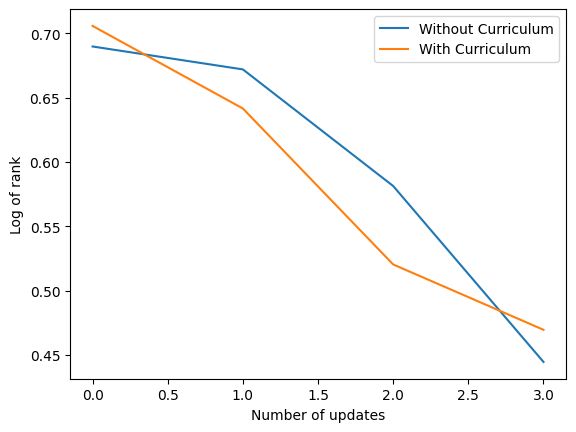

In [ ]:
### Plotting the results

fig, ax = plt.subplots()
import numpy as np
x_cord_collect = range(0, len(collect_ranks))
plt.plot(x_cord_collect, collect_ranks, label='Without Curriculum')
#plt.plot(y1, collect_ranks, label='Without Curriculum')

x_cord_ranks = range(0, len(ranks_cl))
plt.plot(x_cord_ranks, ranks_cl, label='With Curriculum')
#plt.plot(y, ranks_cl, label='With Curriculum')

#x= np.arange(1690986, 15218874, 1690986)
#ame = ['1.6M', '3.2M', '4.8M', '6.4M', '8M', '9.6M', '11.2M', '12.8M']
#plt.xticks(x, name)
#plt.xticks(x)
ax.set_xlabel('Number of updates')
ax.set_ylabel('Log of rank')

plt.legend()

plt.show()

In [ ]:
### LSTM model
with open("wiki.train_.txt", "r") as file:
    train_data = file.readlines()
with open("wiki.valid_.txt", "r") as file:
    val_data = file.readlines()

In [ ]:
tokenizer = get_tokenizer('basic_english')
#train_words = tokenizer(train_data)
#train_words[:10]
from torch.nn.functional import one_hot

class Vocabulary(Dataset):
  def __init__(self, wikidata, tokenizer):
    self.tokenizer = tokenizer
    self.wikidata = wikidata

    # actual length of train vocab is 66057

    self.corpus_vocab = build_vocab_from_iterator(map(self.tokenizer, wikidata), max_tokens= 28000)
    self.corpus_vocab.set_default_index(0)

  def word_to_idx(self, word):
    return self.corpus_vocab.get_stoi()[word]

  def idx_to_word(self, idx):
    return self.corpus_vocab.get_itos()[idx]

  def __len__(self):
    return len(self.corpus_vocab)

def data_process(vocabulary, raw_text_iter: dataset.IterableDataset) -> Tensor:
    data = [torch.tensor(vocabulary.corpus_vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]

    return torch.cat(tuple(filter(lambda t: bool(t.numel()), data)))

class Wikipedia_Dataloader(Dataset):
  def __init__(self, corpus, vocab_len):
    self.corpus = corpus
    self.vocab_len =  vocab_len
    self.seq_len = 32

  def __len__(self):
    return len(self.corpus)

  def __getitem__(self, idx):
    x = self.corpus[idx : idx + self.seq_len]
    y= self.corpus[idx + self.seq_len]
    #y = one_hot(y, num_classes=20000)

    return x, y

vocabulary = Vocabulary(train_data, tokenizer)
train_iter = data_process(vocabulary, train_data)
wiki_data_train = Wikipedia_Dataloader(train_iter, 20000)
data_loader = DataLoader(wiki_data_train, batch_size= 128, drop_last=True)
len(vocabulary)
#vocabulary_v = Vocabulary(valid_data, tokenizer)
val_iter = data_process( vocabulary, val_data)
wiki_data_valid = Wikipedia_Dataloader(val_iter, 20000)
data_loader_valid = DataLoader(wiki_data_valid, batch_size= 128, drop_last=True)

def validate_window(x_, y_, vocab_size) -> Tuple[Tensor, Tensor]:
    #print(vocab_size)
    condition = torch.all(torch.lt(x_, vocab_size), dim=1)
    indices = torch.nonzero(condition)
    #print(indices)
    #print(condition)

    if len(indices) == 0:
        return torch.tensor([]), torch.tensor([])

    x_ = torch.index_select(x_, 0, indices.flatten())
    y_ = torch.index_select(y_, 0, indices.flatten())

    return x_, y_

In [ ]:
if torch.cuda.is_available():
    print(f"Number of available GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available")

# Set the correct device index (assuming the first GPU is available)
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

class My_LSTM(nn.Module):
    def __init__(self, features_vocab_total_words, target_vocab_total_words, embedding_dim, hidden_dim):
        super(My_LSTM, self).__init__()
        self.embedding = nn.Embedding(features_vocab_total_words, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        #self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, target_vocab_total_words)

    def forward(self, x):
        x = x.to(self.embedding.weight.device)
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        #lstm_out = self.dropout(lstm_out)
        output = self.fc(lstm_out[:, -1, :])
        return output

embedding_dim = 128
hidden_dim = 256
epochs = 5
model = My_LSTM(len(vocabulary),len(vocabulary), embedding_dim=128, hidden_dim=256).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=4, eta_min=9e-3)

Number of available GPUs: 1
GPU 0: Tesla T4


In [ ]:
if torch.cuda.is_available():
    print(f"Number of available GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available")

# Set the correct device index (assuming the first GPU is available)
result = []
device = torch.device(0 if torch.cuda.is_available() else 'cpu')
loss_fn = nn.CrossEntropyLoss()
epochs = 4
for e in range(epochs):
    losses = 0.0
    total = 0.0
    correct = 0.0
    correct_v = 0.0
    total_v = 0.0
    model.train()
    for i, batch in enumerate(tqdm(data_loader)):
        x, y = batch
        x, y = x.to(device), y.to(device)
        x,y = validate_window(x, y, 20000)
        if x.numel() == 0:
            continue
        y_ = one_hot(y, num_classes=len(vocabulary))

        # Forward pass through the LSTM generator
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn(outputs, y_.float())
        loss.backward()
        optimizer.step()
        losses += loss.item()
        _, pred = torch.max(outputs.data, 1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    print(f"Epoch {e+1}/{epochs} Loss: {correct/total}")
    print(f"Epoch {e+1}/{epochs} Loss: {losses/len(data_loader)}")
    with torch.no_grad():
        losses = 0.0
        model.eval()
        for i, batch in enumerate(data_loader_valid):
            x, y = batch
            x, y = x.to(device), y.to(device)
            x,y = validate_window(x, y, 20000)
            if x.numel() == 0:
                continue
            y_ = one_hot(y, num_classes=len(vocabulary))
            outputs = model(x)
            loss = loss_fn(outputs, y_.float())
            losses += loss.item()
            _, pred_v = torch.max(outputs.data, 1)
            correct_v += (pred_v == y).sum().item()
            total_v += y.size(0)
        print(f"Validation Acc: {correct_v/total_v}")
        print(f"Validation Loss: {losses/len(data_loader_valid)}")
        result.append(losses/len(data_loader_valid))
    #scheduler.step()


#pred.shape

Number of available GPUs: 1
GPU 0: Tesla T4


100%|██████████| 13238/13238 [01:37<00:00, 136.00it/s]


Epoch 1/4 Loss: 0.06288024678149852
Epoch 1/4 Loss: 10.050655970924263
Validation Acc: 0.08264779031949493
Validation Loss: 9.723790736487318


100%|██████████| 13238/13238 [01:36<00:00, 136.96it/s]


Epoch 2/4 Loss: 0.07818016475874612
Epoch 2/4 Loss: 8.768441314584882
Validation Acc: 0.08352342128886991
Validation Loss: 7.7680181434480735


100%|██████████| 13238/13238 [01:36<00:00, 136.88it/s]


Epoch 3/4 Loss: 0.07857066438429443
Epoch 3/4 Loss: 7.897529574243085
Validation Acc: 0.09408617974717076
Validation Loss: 7.449075004858091


100%|██████████| 13238/13238 [01:36<00:00, 137.05it/s]


Epoch 4/4 Loss: 0.08109732177882387
Epoch 4/4 Loss: 7.667560415373123
Validation Acc: 0.10138187811805566
Validation Loss: 7.2802480857659555


In [ ]:
train_loader = []
for i in range(4):
    vocabulary = Vocabulary(train_data, tokenizer)
    train_iter = data_process(vocabulary, train_data)
    wiki_data_train = Wikipedia_Dataloader(train_iter, 5000*(i+1))
    loader = DataLoader(wiki_data_train, batch_size= 128, drop_last=True)
    train_loader.append(loader)
    len(vocabulary)
#vocabulary_v = Vocabulary(valid_data, tokenizer)
val_iter = data_process( vocabulary, val_data)
wiki_data_valid = Wikipedia_Dataloader(val_iter, 20000)
data_loader_valid = DataLoader(wiki_data_valid, batch_size= 128, drop_last=True)

In [ ]:
if torch.cuda.is_available():
    print(f"Number of available GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available")

# Set the correct device index (assuming the first GPU is available)
device = torch.device(0 if torch.cuda.is_available() else 'cpu')
loss_fn = nn.CrossEntropyLoss()
model_ = My_LSTM(len(vocabulary),len(vocabulary), embedding_dim=128, hidden_dim=256).to(device)
optimizer = torch.optim.SGD(model_.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=4, eta_min=9e-3)
epochs = 1
results = []
for i in range(4):

    for e in range(epochs):
        losses = 0.0
        total = 0.0
        correct = 0.0
        correct_v = 0.0
        total_v = 0.0
        model_.train()
        for _, batch in enumerate(tqdm(train_loader[i])):
            x, y = batch
            x, y = x.to(device), y.to(device)
            x,y = validate_window(x, y, 5000*(i+1))
            if x.numel() == 0:
                continue
            y_ = one_hot(y, num_classes=len(vocabulary))

            # Forward pass through the LSTM generator
            optimizer.zero_grad()
            outputs = model_(x)
            loss = loss_fn(outputs, y_.float())
            loss.backward()
            optimizer.step()
            losses += loss.item()
            _, pred = torch.max(outputs.data, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)

        print(f"Epoch {e+1}/{epochs} Loss: {correct/total}")
        print(f"Epoch {e+1}/{epochs} Loss: {losses/len(train_loader[i])}")
        with torch.no_grad():
            losses = 0.0
            model_.eval()
            for _, batch in enumerate(data_loader_valid):
                x, y = batch
                x, y = x.to(device), y.to(device)
                x,y = validate_window(x, y, 20000)
                if x.numel() == 0:
                    continue
                y_ = one_hot(y, num_classes=len(vocabulary))
                outputs = model_(x)
                loss = loss_fn(outputs, y_.float())
                losses += loss.item()
                _, pred_v = torch.max(outputs.data, 1)
                correct_v += (pred_v == y).sum().item()
                total_v += y.size(0)
            print(f"Validation Acc: {correct_v/total_v}")
            print(f"Validation Loss: {losses/len(data_loader_valid)}")
            print(f"Validation Loss: {losses/len(data_loader_valid)}")
            results.append(losses/len(data_loader_valid))
        scheduler.step()


#pred.shape

Number of available GPUs: 1
GPU 0: Tesla T4


100%|██████████| 13238/13238 [00:29<00:00, 445.86it/s]


Epoch 1/1 Loss: 0.02158597452206346
Epoch 1/1 Loss: 3.2692719731991486
Validation Acc: 0.07828067283778016
Validation Loss: 10.118127058443363
Validation Loss: 10.118127058443363


100%|██████████| 13238/13238 [00:59<00:00, 223.24it/s]


Epoch 1/1 Loss: 0.07952731425291618
Epoch 1/1 Loss: 7.79747265927614
Validation Acc: 0.08264779031949493
Validation Loss: 7.832868616137884
Validation Loss: 7.832868616137884


100%|██████████| 13238/13238 [01:19<00:00, 166.75it/s]


Epoch 1/1 Loss: 0.08271968513116297
Epoch 1/1 Loss: 7.504315983710611
Validation Acc: 0.1023421288869921
Validation Loss: 7.074199363599431
Validation Loss: 7.074199363599431


100%|██████████| 13238/13238 [01:37<00:00, 136.33it/s]


Epoch 1/1 Loss: 0.09378855960914376
Epoch 1/1 Loss: 7.228130457047916
Validation Acc: 0.11082618357345735
Validation Loss: 6.864901943544371
Validation Loss: 6.864901943544371


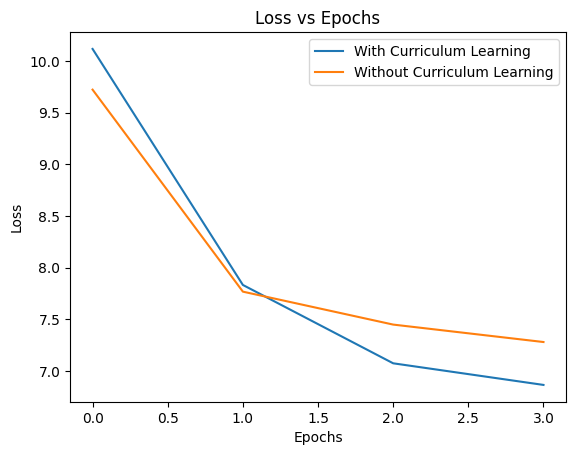

In [ ]:
plt.plot(results, label= 'With Curriculum Learning')
plt.plot(result, label= 'Without Curriculum Learning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()